In [1]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
from sklearn.preprocessing import normalize
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_validate

Using TensorFlow backend.
C:\app\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [ ]:
with open('Word2Vec_X_data_colitis.pkl', 'rb') as f:
    X_data = pickle.load(f)
with open('Word2Vec_y_data_colitis.pkl', 'rb') as f:
    y_data = pickle.load(f)
with open('Word2Vec_embedding_matrix_colitis.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

In [ ]:
def plot_history(history):
    """ A method taken from https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding that
        effectively plots the training and validation accuracy and loss data and diplays it. """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
vocab_size = 6454
embedding_dim = 150
maxlen = 11976
num_filters = 400
window_size =5

In [85]:
#Creation of the neural network with the pretrained embedding matrix.
model_with_embedding = Sequential()
model_with_embedding.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
#model_with_embedding.add(layers.GlobalMaxPool1D())
model_with_embedding.add(layers.Conv1D(num_filters, window_size, activation='relu', padding='same'))
model_with_embedding.add(layers.GlobalMaxPooling1D())
model_with_embedding.add(layers.Dense(30, activation='relu'))
model_with_embedding.add(layers.Dropout(0.5))
model_with_embedding.add(layers.Dense(1, activation='sigmoid'))
model_with_embedding.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_with_embedding.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 11976, 150)        968100    
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 11976, 400)        300400    
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 400)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 30)                12030     
_________________________________________________________________
dropout_15 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 31        
Total params: 1,280,561
Trainable params: 1,280,561
Non-trainable params: 0
___________________________________________

In [125]:
class_weights = {0 : 1,
                1 : 10}
history = model_with_embedding.fit(X_train, y_train,
                    batch_size=32,
                    epochs=1,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights)
'''THR = 0.20
for i in range(50):
    curr_history = model_with_embedding.fit(X_train, y_train,
                    batch_size=32,
                    epochs=1,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights)
    val_loss = curr_history.history['val_loss'][0]
    val_acc = curr_history.history['val_acc'][0]
    if val_acc > 0.945 or val_loss < THR:
        break'''

Train on 623 samples, validate on 156 samples
623/623 [==============================] - 7s 12ms/sample - loss: 0.2379 - acc: 0.9647 - val_loss: 0.1635 - val_acc: 0.9423


"THR = 0.20\nfor i in range(50):\n    curr_history = model_with_embedding.fit(X_train, y_train,\n                    batch_size=32,\n                    epochs=1,\n                    verbose=1,\n                    validation_data=(X_test, y_test),\n                    class_weight=class_weights)\n    val_loss = curr_history.history['val_loss'][0]\n    val_acc = curr_history.history['val_acc'][0]\n    if val_acc > 0.945 or val_loss < THR:\n        break"

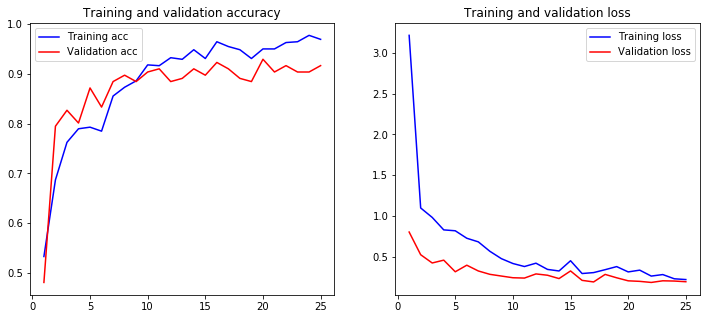

In [88]:
plot_history(history)

In [126]:
thresh = 0.5
y_pred = np.around(model_with_embedding.predict(X_test, batch_size=16), decimals=4)
y_pred_thresh = np.asarray([1 if y_pred[i] > thresh else 0 for i in range(len(y_pred))])

print(classification_report(y_test, y_pred_thresh, output_dict=True))

print(confusion_matrix(y_test, y_pred_thresh))

{'0': {'precision': 0.9577464788732394, 'recall': 0.9784172661870504, 'f1-score': 0.9679715302491103, 'support': 139}, '1': {'precision': 0.7857142857142857, 'recall': 0.6470588235294118, 'f1-score': 0.7096774193548386, 'support': 17}, 'accuracy': 0.9423076923076923, 'macro avg': {'precision': 0.8717303822937625, 'recall': 0.8127380448582311, 'f1-score': 0.8388244748019744, 'support': 156}, 'weighted avg': {'precision': 0.9389993809007894, 'recall': 0.9423076923076923, 'f1-score': 0.9398240950875552, 'support': 156}}
[[136   3]
 [  6  11]]


In [ ]:
#model_with_embedding.save('word2vec_cnn_classifier_07_05_2019.h5') 

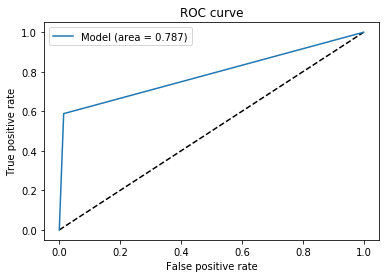

In [82]:
y_pred_keras = y_pred_thresh.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
def show_confusion_matrix(confusion_matrix):
    SMALL_SIZE = 14
    MEDIUM_SIZE = 17
    BIGGER_SIZE = 50

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    ax = plt.subplot()
    confusion_matrix = normalize(confusion_matrix, axis=1, norm='l1')
    sns.heatmap(confusion_matrix ,annot=True, ax = ax, cmap='Blues')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix', fontsize=23)
    ax.xaxis.set_ticklabels(['Normal', 'Colitis'])
    ax.yaxis.set_ticklabels(['Normal', 'Colitis'], va='center')
    #plt.matshow(confusion_matrix_array)
    #plt.colorbar()
    plt.show()

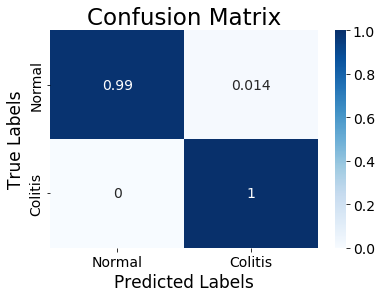

In [110]:
show_confusion_matrix(confusion_matrix(y_test, y_pred))

In [ ]:
def create_network_with_embedding():
    vocab_size = 6454
    embedding_dim = 150
    maxlen = 11976
    num_filters = 256
    window_size = 5
    
    
    #Creation of the neural network with the pretrained embedding matrix.
    model_with_embedding = Sequential()
    model_with_embedding.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=True))
    #model_with_embedding.add(layers.GlobalMaxPool1D())
    model_with_embedding.add(layers.Conv1D(num_filters, window_size, activation='relu', padding='same'))
    model_with_embedding.add(layers.GlobalMaxPooling1D())
    model_with_embedding.add(layers.Dense(30, activation='relu'))
    model_with_embedding.add(layers.Dropout(0.5))
    model_with_embedding.add(layers.Dense(1, activation='sigmoid'))
    model_with_embedding.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model_with_embedding

In [ ]:

neural_network = KerasClassifier(build_fn=create_network_with_embedding, 
                                 epochs=30, 
                                 batch_size=32, 
                                 verbose=2)

In [ ]:
weights = {0 : 1,
           1 : 10}

#model checkpoints, early stop mode specify best, argument: mode
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

score = cross_validate(neural_network, X_data, y_data, cv=5, scoring=['f1', 'precision', 'recall', 'accuracy'], fit_params={'class_weight' : weights, 'callbacks':[callback]})

In [ ]:
np.average(score['test_recall'])

In [ ]:
score